# Задача 2. Линейная регрессия, метод градиентного спуска.

- [✓] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [✓] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [✓] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [✓] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [✓] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [✓] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [✓] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [✓] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [✓] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [✓] * (**+3 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

**Выполнил:** Пушкин Т.Д., группа 471 (20.Б11-мм)

In [1]:
from numbers import Integral, Real
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from scipy.special import expit
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import (
    check_scalar, check_X_y, check_array, check_is_fitted
)

## Реализация методов классификации

Самостоятельно реализуем KNN и логистическую регрессию.

In [2]:
class SimpleKNNClassifier(BaseEstimator, ClassifierMixin):
    """ KNN классификатор без весов на основе евклидова расстояния. """

    def __init__(self, n_neighbors: Integral = 5):
        self.n_neighbors = n_neighbors

    def fit(self, X: npt.ArrayLike, y: npt.ArrayLike) -> "SimpleKNNClassifier":
        self.n_neighbors = check_scalar(self.n_neighbors, "n_neighbors", Integral, min_val=1)
        self.X_, self.y_ = check_X_y(X, y)
        check_classification_targets(self.y_)
        self.n_features_in_ = self.X_.shape[1]  # Требуется sklearn
        self.classes_ = np.unique(self.y_)  # Требуется sklearn
        return self

    @staticmethod
    def _find_most_common(arr: npt.ArrayLike) -> Any:
        elems, counts = np.unique(arr, return_counts=True)
        return elems[np.argmax(counts)]

    def predict(self, X: npt.ArrayLike) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)

        result = np.empty((X.shape[0],), dtype=self.y_.dtype)
        for i, x in enumerate(X):  # check_array гарантирует, что X двумерный
            dists = np.linalg.norm(self.X_ - x, axis=1)
            sorted_dists_idx = np.argsort(dists)
            neighbor_classes = self.y_[sorted_dists_idx][:self.n_neighbors]
            result[i] = SimpleKNNClassifier._find_most_common(neighbor_classes)

        return result


class SimpleLogisticRegression(BaseEstimator, ClassifierMixin):
    """ Классификатор на основе one-versus-all логистической регрессии с L2-регуляризацией. """

    def __init__(self, alpha: Real = 1, *, max_iter: Integral = 1000, tol: Real = 1e-4, eta0: Real = 1):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.eta0 = eta0

    def _fit_binary(self, X: npt.NDArray, y: npt.NDArray) -> (npt.NDArray, Real, int):
        """
        Обучение бинарного классификатора, который будет выделять переданный класс.
        :param X выборка с приписанным в конец столбцом единиц.
        :param y факт принадлежности к целевому для каждого элемента выборки.
        """

        coef = np.zeros(X.shape[1])

        grad = np.inf
        n_iter = 0
        while n_iter < self.max_iter and np.linalg.norm(grad) > self.tol:
            pred = expit(X @ coef)
            grad = X.T @ (pred - y) + 2 * self.alpha * np.pad(coef[:-1], (0, 1))
            n_iter += 1
            coef -= grad * self.eta0 / n_iter

        return coef[:-1], coef[-1], n_iter

    def fit(self, X: npt.ArrayLike, y: npt.ArrayLike) -> "LinearGDRegressor":
        self.alpha = check_scalar(self.alpha, "alpha", Real, min_val=0.0)
        self.max_iter = check_scalar(self.max_iter, "max_iter", Integral, min_val=1)
        self.tol = check_scalar(self.tol, "tol", Real, min_val=0.0)
        self.eta0 = check_scalar(self.eta0, "eta0", Real, min_val=0, include_boundaries="neither")

        X, y = check_X_y(X, y)
        check_classification_targets(y)

        self.classes_ = np.unique(y)
        self.n_features_in_ = X.shape[1]
        X = np.column_stack([X, np.ones(X.shape[0])])

        # Основные коэффициенты (для каждого бинарного классификатора)
        self.coef_ = np.empty((self.classes_.size, self.n_features_in_))
        # Свободный коэффициент (для каждого бинарного классификатора)
        self.intercept_ = np.empty((self.classes_.size,))
        # Число итераций градиентного спуска (у каждого бинарного классификатора)
        self.n_iter_ = np.empty((self.classes_.size,))
        for i, c in enumerate(self.classes_):
            self.coef_[i], self.intercept_[i], self.n_iter_[i] = self._fit_binary(X, y == c)

        return self

    def predict(self, X: npt.ArrayLike) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)
        # Каждой строке X соответствует строка вероятности каждого класса
        class_probs = expit(X @ self.coef_.T + self.intercept_)
        # Для каждой строки X получаем индекс класса с наибольшей вероятностью
        most_likely_class_idx = np.argmax(class_probs, axis=1)
        return self.classes_[most_likely_class_idx]

In [3]:
check_estimator(SimpleKNNClassifier())
check_estimator(SimpleLogisticRegression())

## Сравнение классификаторов на датесете о болезнях сердца

Датасет содержит физиологические данные о пациентах:
- `age` --- возраст
- `sex` --- пол (1 --- мужской, 0 --- женский)
- `cp` --- тип боли в груди (0--3)
- `trestbps` --- давление в состоянии покоя (мм. ртутного столба)
- `chol` --- холестерин в крови (мг/дл)
- `fbs` --- превышает ли уровень сахара в крови натощак 120 мг/дл (1 --- да, 0 --- нет)
- `restecg` --- тип результата ЭКГ в состоянии покоя (0--2)
- `thalach` --- максимальная частота сердцебиения
- `exang` --- наличие стенокардии, вызванной физическими нагрузками (1 --- да, 0 --- нет)
- `oldpeak` --- величина ST-недостаточности, вызванной физическими нагрузками относительно отдыха
- `slope` --- наклон пика ST-сегмента при физических нагрузках
- `ca` --- количество магистральных сосудов, окрашенных флюороскопией (0--3)
- `thal` --- наличие талассемии и её тип (0--3)
- `target` --- присутствует ли болезнь сердца (1 --- да, 0 --- нет)

**Задача**: определить, имеется ли у человека болезнь сердца.

In [4]:
df = pd.read_csv("../data/heart_disease/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Отсутствующих значений в датасете нет, однако присутствуют категориальные признаки без естественного порядка (`sex`, `cp`, `fbs`, `restecg`, `exang`, `thal`, но не `ca`), для которых придётся использовать one-hot кодирование.

### Разведочный анализ (EDA)

Элементы выборки распределены по целевому признаку достаточно равномерно. Следовательно, при обучении можно не бояться, что один из классов в метриках сильно "перевесит" другой.

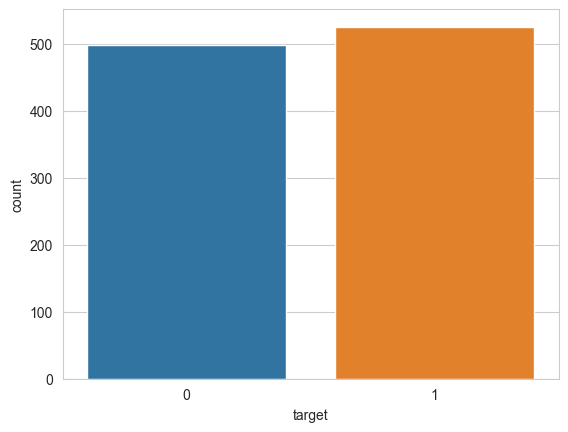

In [7]:
sns.countplot(df, x="target", hue="target", legend=None);

Большей части пациентов около 60 лет. При этом у женщин болезни сердца встречается более-менее равномерно в течение всех представленных возрастов, а у мужчин они чаще встречаются в 41--4 и 51--59 лет.

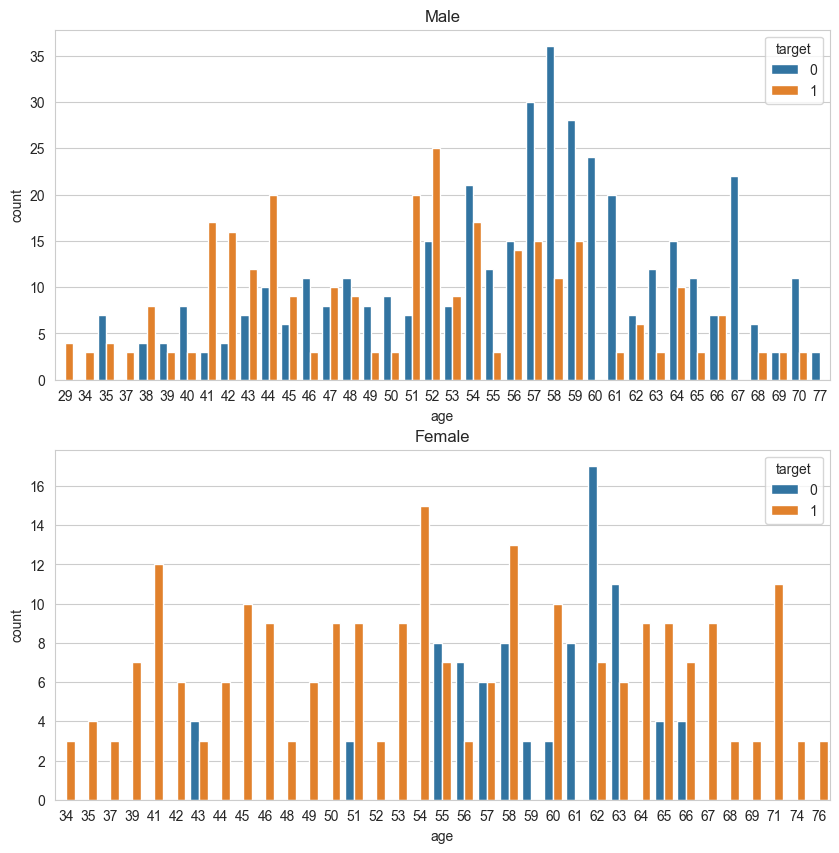

In [8]:
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))
ax1.set_title("Male")
sns.countplot(df[df.sex == 1], x="age", hue="target", ax=ax1)
ax2.set_title("Female")
sns.countplot(df[df.sex == 0], x="age", hue="target", ax=ax2);

Рассматривая прочие категориальные признаки, можно заметить, что в каждом из них распределение неравномерное, присутствуют значения с относительно большим числом заболевших. Это должно поспособствовать успешному определению заболевших по данным признакам.

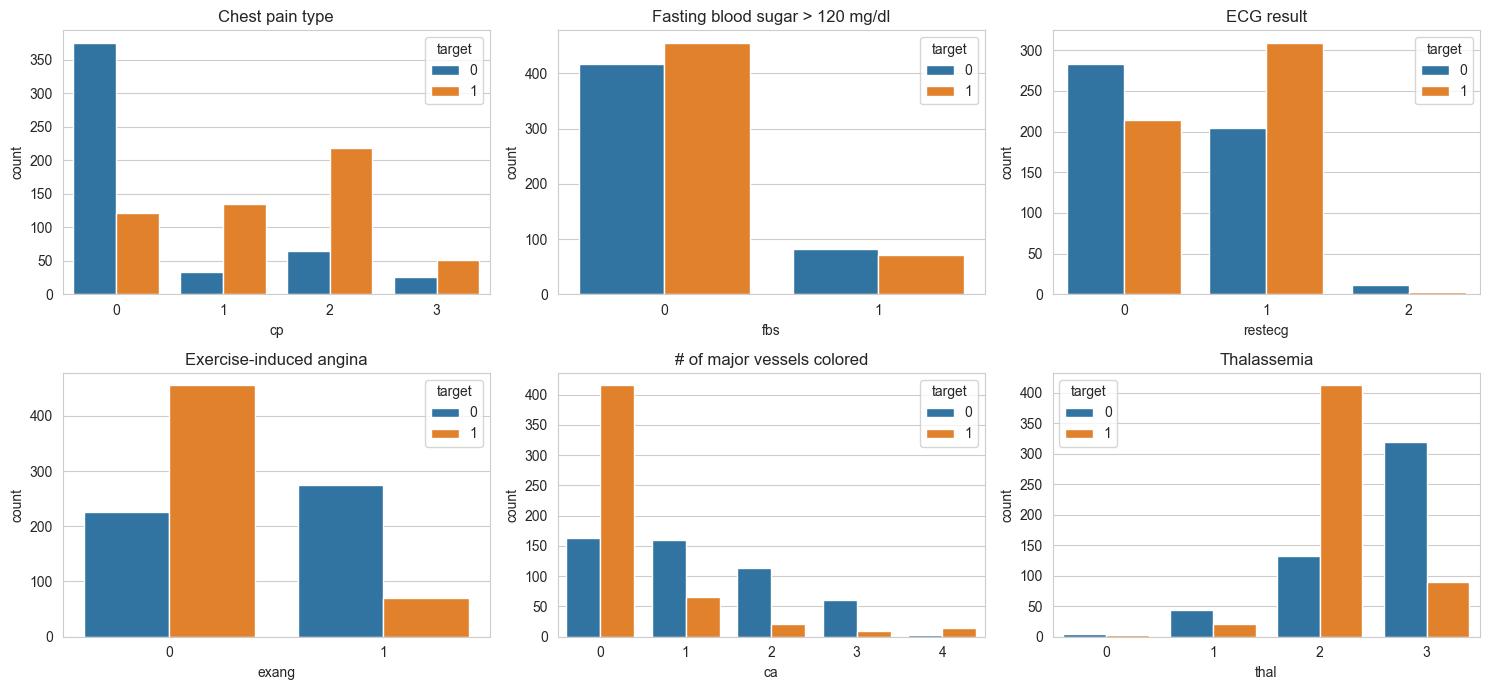

In [9]:
_, axs = plt.subplots(2, 3, figsize=(15, 7), tight_layout=True)
sns.countplot(df, x="cp", hue="target", ax=axs[0, 0]).set_title("Chest pain type")
sns.countplot(df, x="fbs", hue="target", ax=axs[0, 1]).set_title("Fasting blood sugar > 120 mg/dl")
sns.countplot(df, x="restecg", hue="target", ax=axs[0, 2]).set_title("ECG result")
sns.countplot(df, x="exang", hue="target", ax=axs[1, 0]).set_title("Exercise-induced angina")
sns.countplot(df, x="ca", hue="target", ax=axs[1, 1]).set_title("# of major vessels colored")
sns.countplot(df, x="thal", hue="target", ax=axs[1, 2]).set_title("Thalassemia");

У некатегориальных признаков сильной взаимной зависимости не наблюдается (разве что у `oldpeak` и `slope` есть повышенная отрицательная корреляция, но это ожидаемо, так как они оба описывают ST-сегмент ЭКГ).

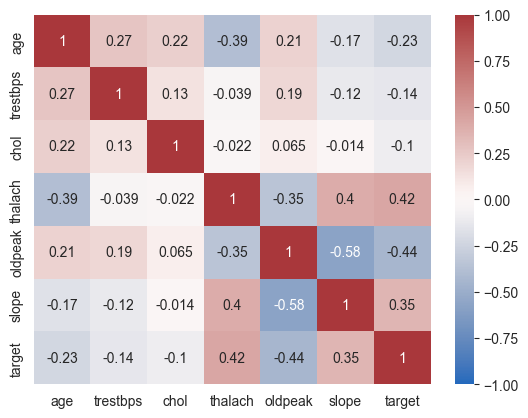

In [10]:
sns.heatmap(
    df.drop(columns=["sex", "cp", "fbs", "restecg", "exang", "ca", "thal"]).corr(),
    vmin=-1, vmax=1, annot=True, cmap="vlag",
);

### Обучение и сравнение моделей

Разделим датасет на целевые и нецелевые признаки. Также выделим небольшой тестовый набор для построения confusion-матриц.

In [11]:
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42, stratify=y)

В случае данного датасета мы хотим максимально верно определять всех пациентов с болезнями, чтобы начать их лечить (false negative --- плохо, так как пациент умрёт). И при этом, если мы неверно определим здорового как больного, ничего особо страшного не произойдёт: последующие анализы выявят, что он здоров, и лечение прервётся (false positive --- не так страшно). Следовательно, в качестве метрики будем использовать recall.

In [12]:
def make_pipeline(estimator):
    transformer = make_column_transformer(
        (StandardScaler(), ["age", "trestbps", "chol", "thalach", "oldpeak", "slope"]),
        (OneHotEncoder(), ["sex", "cp", "fbs", "restecg", "exang", "thal"])
    )
    return Pipeline([("transformer", transformer), ("estimator", estimator)])


def train(estimator, scoring: str, param_grid: dict):
    pipeline = make_pipeline(estimator)
    param_grid = {f"estimator__{name}": val for name, val in param_grid.items()}

    cv = GridSearchCV(
        pipeline,
        param_grid,
        scoring=scoring,
        n_jobs=6,
    )
    cv.fit(X_train, y_train)

    print(estimator.__class__.__name__)
    print("Train score:", "{:.2f}".format(cv.best_score_))
    print("Test recall:", "{:.2f}".format(recall_score(y_test, cv.best_estimator_.predict(X_test))))
    print(
        "Best params:",
        {name.removeprefix("estimator__"): val for name, val in cv.best_params_.items()},
    )

    ax = ConfusionMatrixDisplay.from_estimator(
        cv.best_estimator_,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
    ).ax_
    ax.set_title("Test results")
    ax.grid(False)

SimpleLogisticRegression
Train score: 0.96
Test recall: 0.98
Best params: {'alpha': 2, 'eta0': 10, 'tol': 1e-06}


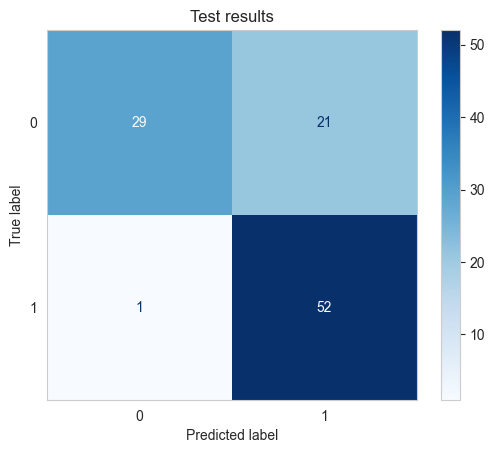

In [13]:
train(
    SimpleLogisticRegression(),
    "recall",
    {
        "alpha": [0.01, 0.1, 1, 2, 5],
        "tol": [1e-6, 1e-5, 1e-4, 1e-3],
        "eta0": [0.1, 1, 10, 20],
    }
)

Recall хороший, но precision не очень. Попробуем с F1.

SimpleLogisticRegression
Train score: 0.83
Test recall: 0.79
Best params: {'alpha': 2, 'eta0': 0.1, 'tol': 1e-06}


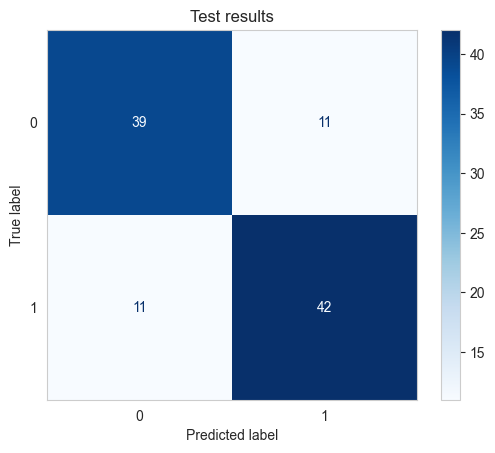

In [14]:
train(
    SimpleLogisticRegression(),
    "f1",
    {
        "alpha": [0.01, 0.1, 1, 2, 5],
        "tol": [1e-6, 1e-5, 1e-4, 1e-3],
        "eta0": [0.1, 1, 10, 20],
    }
)

LogisticRegression
Train score: 0.85
Test recall: 0.81
Best params: {'C': 0.9, 'max_iter': 100, 'tol': 1e-06}


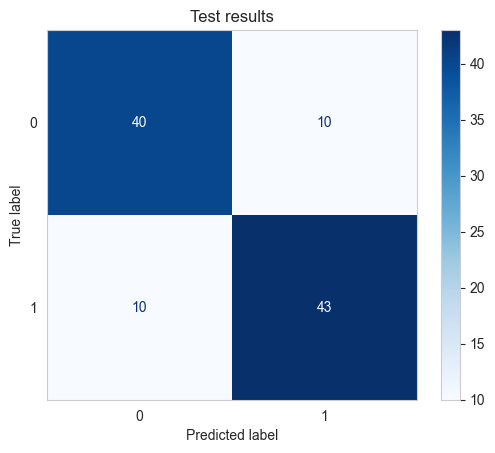

In [15]:
train(
    LogisticRegression(n_jobs=2, random_state=42),
    "recall",
    {
        "tol": [1e-6, 1e-5, 1e-4],
        "C": [0.1, 0.5, 0.9, 1, 2],
        "max_iter": [100, 200],
    }
)

SimpleKNNClassifier
Train score: 0.90
Test recall: 1.00
Best params: {'n_neighbors': 3}


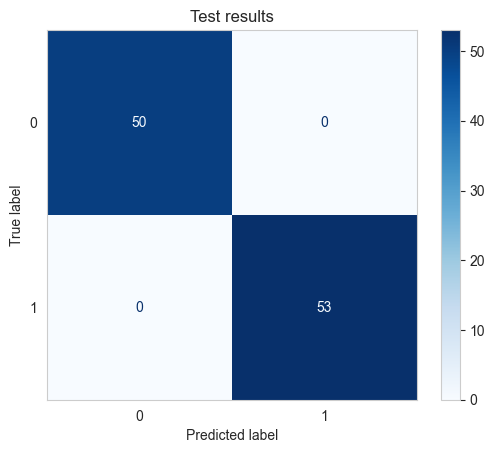

In [16]:
train(
    SimpleKNNClassifier(),
    "recall",
    {"n_neighbors": [3, 5, 7, 9]},
)

KNeighborsClassifier
Train score: 0.99
Test recall: 1.00
Best params: {'metric': 'cosine', 'n_neighbors': 7, 'weights': 'distance'}


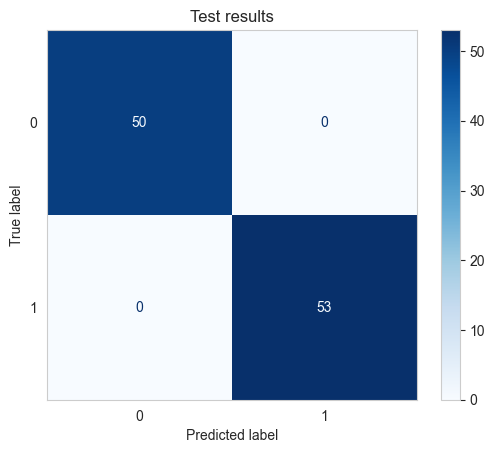

In [17]:
train(
    KNeighborsClassifier(n_jobs=2),
    "recall",
    {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "metric": ["cosine", "euclidean", "manhattan"],
    }
)

SVC
Train score: 1.00
Test recall: 1.00
Best params: {'C': 0.01, 'coef0': 0, 'gamma': 'auto', 'kernel': 'poly', 'tol': 1e-06}


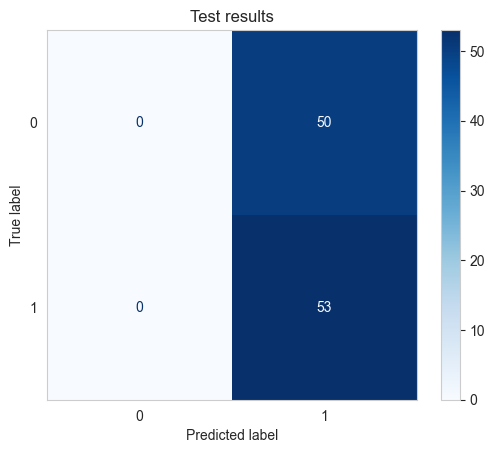

In [18]:
train(
    SVC(random_state=42),
    "recall",
    {
        "C": [0.01, 0.1, 1, 10],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma": ["scale", "auto"],
        "coef0": [0, 1],
        "tol": [1e-6, 1e-5, 1e-4, 1e-3],
    }
)

Для таких ответов и модель не нужна :) Попробуем с F1.

SVC
Train score: 0.97
Test recall: 0.98
Best params: {'C': 10, 'coef0': 1, 'gamma': 'scale', 'kernel': 'poly', 'tol': 1e-06}


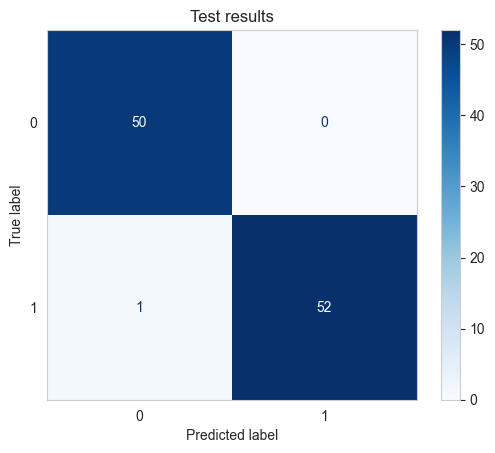

In [19]:
train(
    SVC(random_state=42),
    "f1",
    {
        "C": [0.01, 0.1, 1, 10],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma": ["scale", "auto"],
        "coef0": [0, 1],
        "tol": [1e-6, 1e-5, 1e-4, 1e-3],
    }
)

Из всего семейства Naive Bayes алгоритмов для данного датасета лучше всего подойдёт гауссовский, так как присутствуют непрерывные признаки, да и дискретные имеют распределения, близкие к нормальному.

GaussianNB
Train score: 0.86
Test recall: 0.81
Best params: {'var_smoothing': 1e-09}


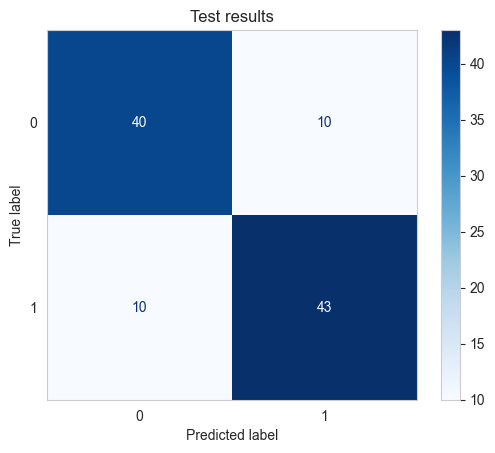

In [20]:
train(
    GaussianNB(),
    "recall",
    {"var_smoothing": [1e-9, 1e-8, 1e-5, 1e-3]},
)

DecisionTreeClassifier
Train score: 0.99
Test recall: 1.00
Best params: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'splitter': 'random'}


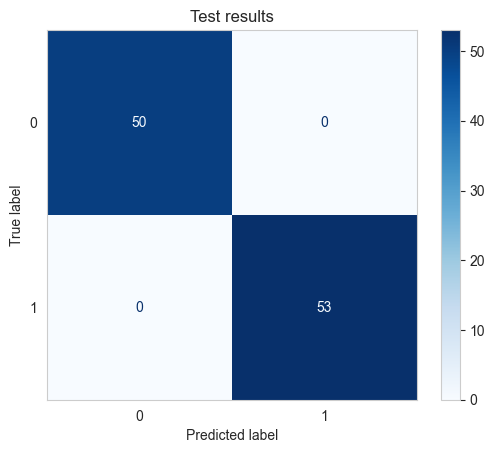

In [21]:
train(
    DecisionTreeClassifier(random_state=42),
    "recall",
    {
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "max_depth": [None, 50, 100, 500],
        "min_samples_split": [2, 3, 5],
        "min_samples_leaf": [1, 2, 5],
        "min_weight_fraction_leaf": [0, 0.01, 0.1],
        "max_leaf_nodes": [None, 50, 100, 500],
    },
)

В целом, все модели справились с задачей хорошо:
- Встроенные в scikit-learn логистическая регрессия и гауссовский naive bayes выдают сравнительно посредственные результаты: recall равен 0.85-0.86 и 0.81 на тренировочной и тестовой выборке соответственно
- Реализованная вручную логистическая регрессия при тренировке, нацеленной на recall, действительно показывает хороший recall (0.96 и 0.98 на тренировочной и тестовой выборке соответственно), однако при этом ощутимо страдает precision (на тестовой выборке она равна 0.71); при тренировке же, нацеленной на F1, ухудшается recall (до 0.79 на тестовой выборке)
- Реализованная вручную KNN выдаёт вполне неплохой результат: recall на тренировочной выборке равен 0.9, а на тестовой верно предсказаны вообще все случаи
- SVM-классификатор при тренировке, нацеленной на recall, вырождается в константный положительный ответ, но при нацеливании на F1 показывает достойный результат (0.97 F1 на тренировочной выборке, идеальный precision и 0.98 recall --- на тестовой)
- Встроенные в scikit-learn KNN и DecisionTreeClassifier показывают наилучший результат: 0.99 recall на тренировочной выборке и идеальные ответы на тестовой

Таким образом, для данного датасета лучше всего подходят встроенные в scikit-learn KNN и DecisionTreeClassifier.

## Сравнение классификаторов на другом датесете

[Датасет](https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023) содержит данные о факте мошенничестве с кредитными картами в Европе в 2023 году:
- `id` --- уникальный идентификатор транзакции
- `V1`--`V28` --- различные обезличенные характеристики транзакции (время, место и другие)
- `Amount` --- размер транзакции
- `Class` --- является ли транзакция мошеннической (1 --- да, 0 --- нет)

**Задача**: определить, является ли транзакция мошеннической.

Оригинальный датасет содержит более полумиллиона записей, из-за чего некоторые модели учатся на нём слишком долго. Возьмём лишь каждый десятый элемент.

In [14]:
df = pd.read_csv("datasets/creditcard_2023_every_10th.csv")
df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,10,1.206014,-0.883519,1.021299,-1.410047,-0.341591,0.101491,0.036318,-0.141480,-0.348832,...,-0.106932,0.252151,0.004350,1.065933,0.330100,-0.289691,-0.188490,-0.060815,4741.71,0
2,20,0.608595,-0.958163,1.105915,-0.278201,-0.135043,1.174674,0.172058,-0.049052,0.244392,...,-0.223727,-0.548898,-0.075119,-0.515754,0.033401,-1.029816,-0.137285,0.053353,940.72,0
3,30,1.022980,-0.423938,0.675013,-0.305698,0.122293,0.184073,0.435255,-0.182498,0.778155,...,-0.203127,-0.513716,-0.068466,0.189861,0.766054,0.642997,-0.263605,-0.071494,20901.22,0
4,40,1.032732,-0.669437,0.203922,-1.167525,0.942578,2.311695,0.117585,0.077777,1.074196,...,-0.105724,-0.034599,-0.153714,2.497014,0.751081,2.317873,-0.292292,-0.087799,10890.50,0


In [15]:
df.describe()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,56863.000000,56863.000000,56863.000000,56863.000000,56863.000000,56863.000000,56863.000000,56863.000000,56863.000000,56863.000000,...,56863.000000,56863.000000,56863.000000,56863.000000,56863.000000,56863.000000,56863.000000,56863.000000,56863.000000,56863.000000
mean,284310.000000,-0.002317,0.005721,0.000220,0.002080,-0.003242,-0.000448,0.000834,0.000552,0.001247,...,0.004326,-0.004840,0.002463,0.000794,0.001634,0.006617,-0.001499,-0.000976,12026.016487,0.499886
std,164150.785154,1.000872,0.986605,1.002396,0.998252,1.011708,1.002579,0.977873,1.005096,1.001522,...,1.003808,1.001479,1.000516,1.000706,0.998371,0.997161,0.987503,0.994174,6928.103821,0.500004
min,0.000000,-2.908410,-28.155685,-2.518308,-4.872165,-4.580605,-18.642598,-4.350205,-6.530216,-3.751077,...,-12.157375,-6.450353,-21.504910,-3.984004,-8.906746,-4.773707,-5.956088,-20.720071,50.280000,0.000000
25%,142155.000000,-0.571500,-0.484646,-0.656749,-0.656886,-0.291766,-0.447582,-0.287491,-0.191274,-0.572097,...,-0.165893,-0.492504,-0.237296,-0.646257,-0.549103,-0.627473,-0.304466,-0.229748,5991.945000,0.000000
50%,284310.000000,-0.093531,-0.132891,0.000880,-0.069892,0.084036,0.079026,0.231683,-0.113277,0.095272,...,-0.037177,-0.028995,-0.059238,0.015164,-0.000660,-0.001875,-0.171514,-0.013726,12020.920000,0.000000
75%,426465.000000,0.832639,0.352396,0.631730,0.711529,0.436123,0.492978,0.525288,0.047948,0.561042,...,0.146674,0.462068,0.157863,0.698878,0.548813,0.676784,0.337868,0.409090,18035.935000,1.000000
max,568620.000000,2.166056,4.359827,4.211192,2.392292,41.540257,9.352413,41.880045,5.958040,12.107343,...,8.087080,9.765390,28.992365,10.975795,11.048319,5.555557,17.987212,36.678192,24039.550000,1.000000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56863 entries, 0 to 56862
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      56863 non-null  int64  
 1   V1      56863 non-null  float64
 2   V2      56863 non-null  float64
 3   V3      56863 non-null  float64
 4   V4      56863 non-null  float64
 5   V5      56863 non-null  float64
 6   V6      56863 non-null  float64
 7   V7      56863 non-null  float64
 8   V8      56863 non-null  float64
 9   V9      56863 non-null  float64
 10  V10     56863 non-null  float64
 11  V11     56863 non-null  float64
 12  V12     56863 non-null  float64
 13  V13     56863 non-null  float64
 14  V14     56863 non-null  float64
 15  V15     56863 non-null  float64
 16  V16     56863 non-null  float64
 17  V17     56863 non-null  float64
 18  V18     56863 non-null  float64
 19  V19     56863 non-null  float64
 20  V20     56863 non-null  float64
 21  V21     56863 non-null  float64
 22

Отсутствующих значений в датасете нет. Также нет и категориальных признаков (кроме целевого). Однако, сразу отбросим признак `id`, так как он вряд ли несёт полезную информацию (по сути, он просто дублирует порядковый номер).

In [17]:
df = df.drop(columns=["id"])

### Разведочный анализ (EDA)

Выборка равномерно распределена по целевому признаку.

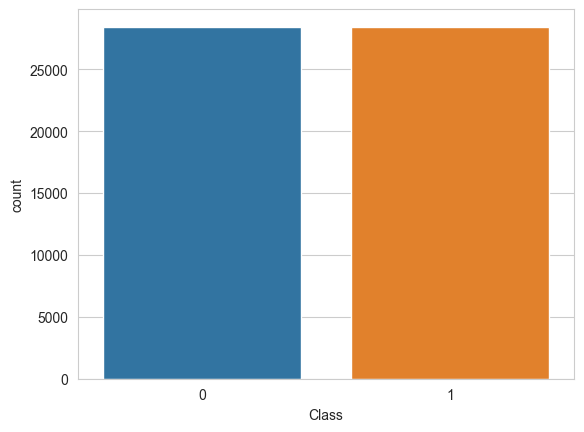

In [18]:
sns.countplot(df, x="Class", hue="Class", legend=None);

По размеру транзакции также распределены равномерно, как и факты мошенничества по величине транзакции.

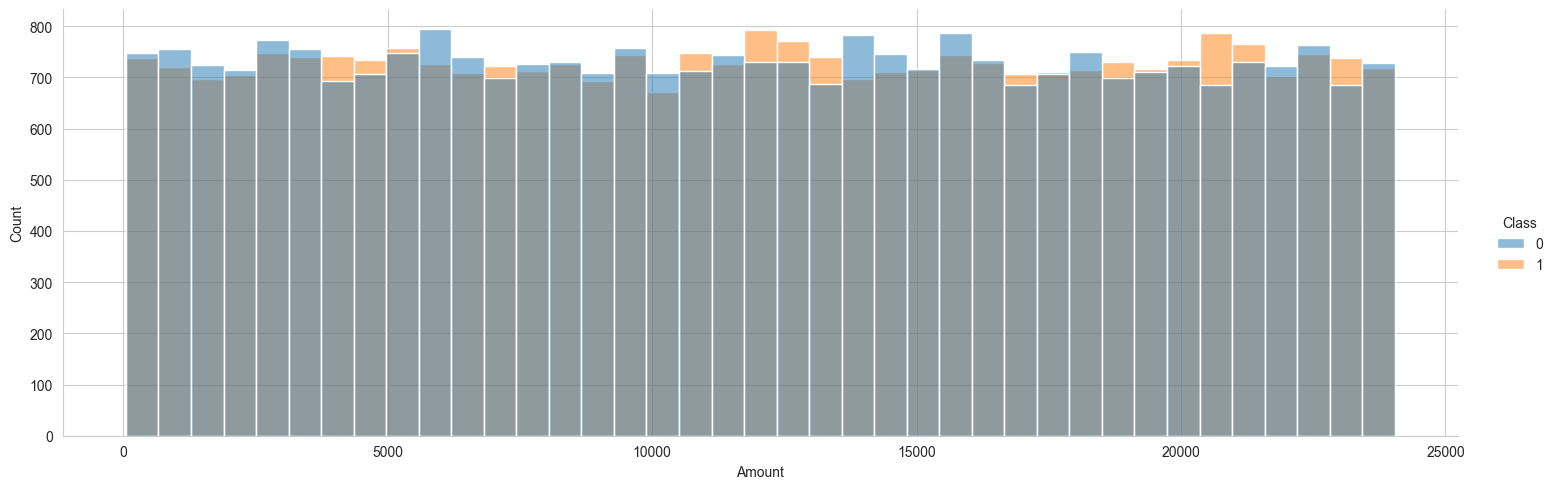

In [19]:
sns.displot(df, x="Amount", hue="Class", stat="count", aspect=3);

Между некоторыми признаками есть ощутимая корреляция, особенно между `V9`--`V12` и `V16`--`V18`. Так как признаки обезличены, неясно, ожидаемая это ситуация или нет.

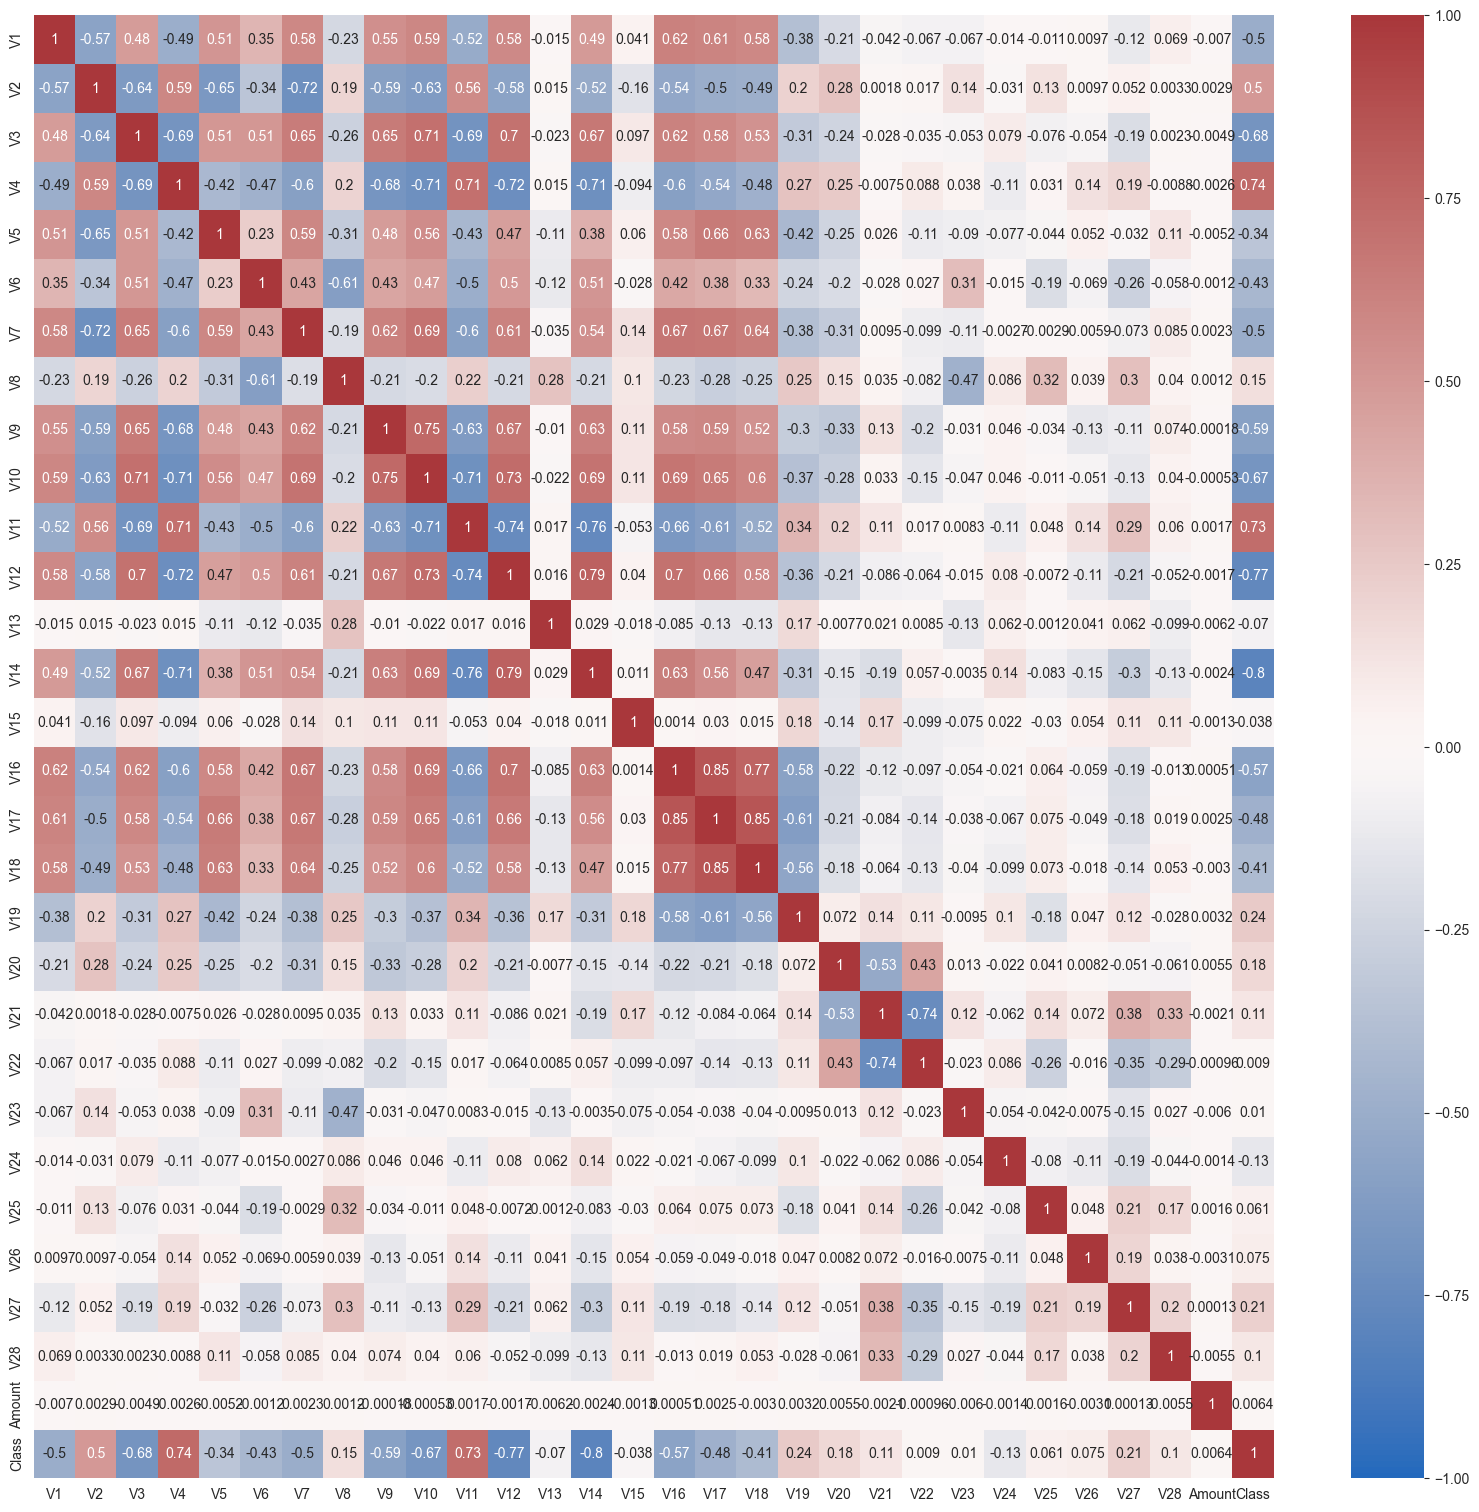

In [20]:
plt.figure(figsize=(20, 19))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap="vlag");

### Обучение и сравнение моделей

Вновь разделим датасет на целевые и нецелевые признаки, а также выделим тестовый набор для построения confusion-матриц.

In [21]:
X = df.drop(columns=["Class"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42, stratify=y)

Для данного датасета нам снова наилучшим образом подходит recall. В случае мошенничества мы хотим гарантированно блокировать карту, при этом ошибочная блокировка не так страшна, так как клиент может обратиться в банк для разблокировки.

In [22]:
def make_pipeline(estimator):
    transformer = make_column_transformer((StandardScaler(), X.columns))
    return Pipeline([("transformer", transformer), ("estimator", estimator)])


def train(estimator, scoring: str, param_grid: dict):
    pipeline = make_pipeline(estimator)
    param_grid = {f"estimator__{name}": val for name, val in param_grid.items()}

    cv = GridSearchCV(
        pipeline,
        param_grid,
        scoring=scoring,
        n_jobs=6,
    )
    cv.fit(X_train, y_train)

    print(estimator.__class__.__name__)
    print("Train score:", "{:.2f}".format(cv.best_score_))
    print("Test recall:", "{:.2f}".format(recall_score(y_test, cv.best_estimator_.predict(X_test))))
    print(
        "Best params:",
        {name.removeprefix("estimator__"): val for name, val in cv.best_params_.items()},
    )

    ax = ConfusionMatrixDisplay.from_estimator(
        cv.best_estimator_,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
    ).ax_
    ax.set_title("Test results")
    ax.grid(False)

SimpleLogisticRegression
Train score: 0.97
Test recall: 0.97
Best params: {'alpha': 0.1, 'eta0': 1, 'tol': 1e-05}


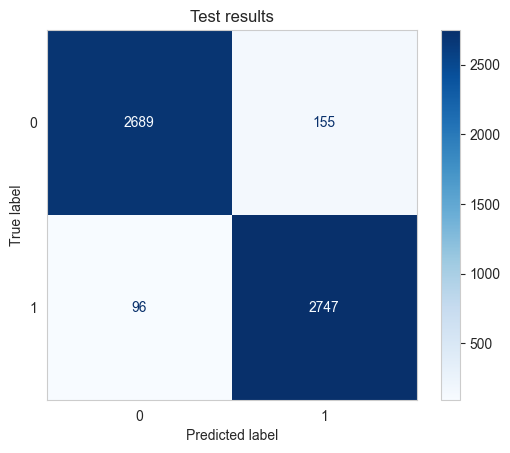

In [24]:
train(
    SimpleLogisticRegression(),
    "recall",
    {
        "alpha": [0.1, 1],
        "tol": [1e-5, 1e-4],
        "eta0": [0.1, 1],
    }
)

LogisticRegression
Train score: 0.95
Test recall: 0.95
Best params: {'C': 2, 'max_iter': 100, 'tol': 1e-06}


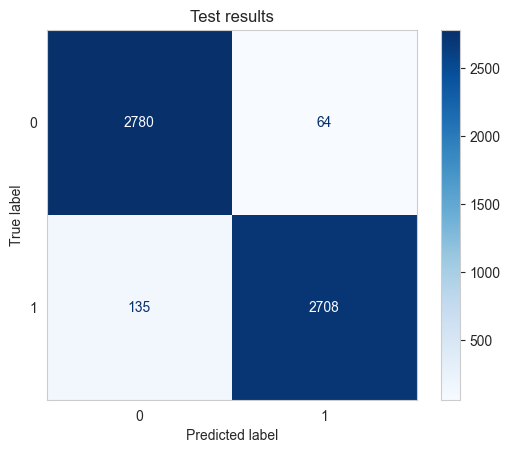

In [23]:
train(
    LogisticRegression(n_jobs=2, random_state=42),
    "recall",
    {
        "tol": [1e-6, 1e-5, 1e-4],
        "C": [0.1, 0.5, 0.9, 1, 2],
        "max_iter": [100, 200],
    }
)

SimpleKNNClassifier
Train score: 1.00
Test recall: 1.00
Best params: {'n_neighbors': 3}


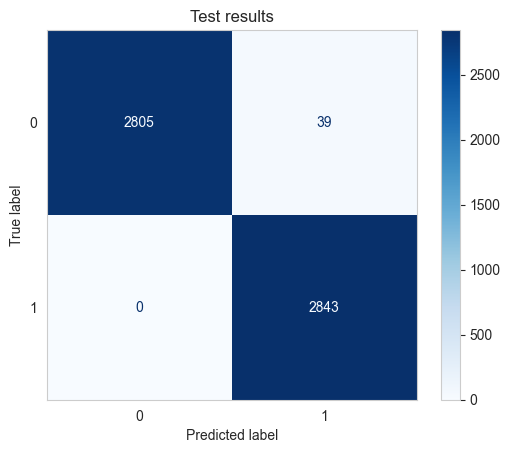

In [35]:
train(
    SimpleKNNClassifier(),
    "recall",
    {"n_neighbors": [3, 5]},
)

KNeighborsClassifier
Train score: 1.00
Test recall: 1.00
Best params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}


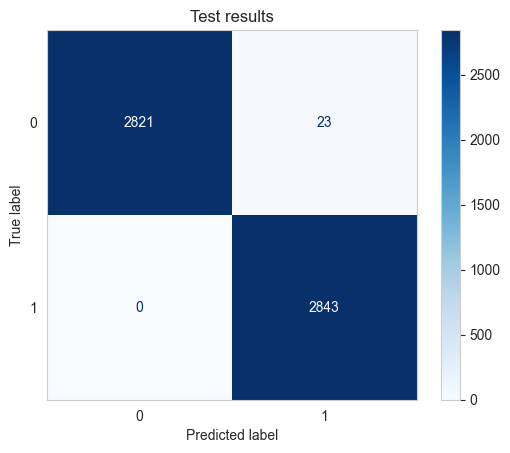

In [29]:
train(
    KNeighborsClassifier(n_jobs=2),
    "recall",
    {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"],
        "metric": ["cosine", "euclidean", "manhattan"],
    }
)

SVC
Train score: 0.98
Test recall: 0.99
Best params: {'kernel': 'rbf'}


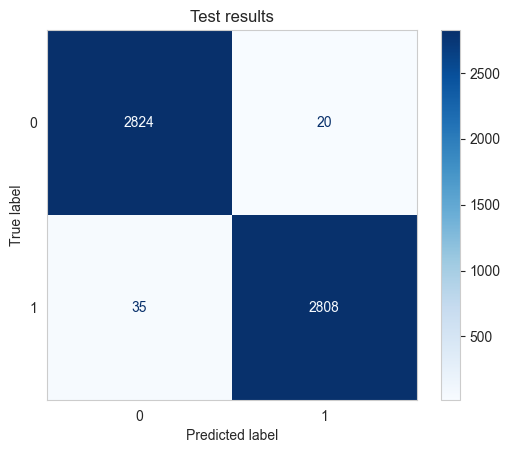

In [34]:
train(
    SVC(random_state=42),
    "recall",
    {"kernel": ["linear", "poly", "rbf", "sigmoid"]},
)

Аналогично предыдущему датасету, из семейства Naive Bayes алгоритмов для данного датасета лучше всего подойдёт гауссовский.

GaussianNB
Train score: 0.86
Test recall: 0.86
Best params: {'var_smoothing': 1e-09}


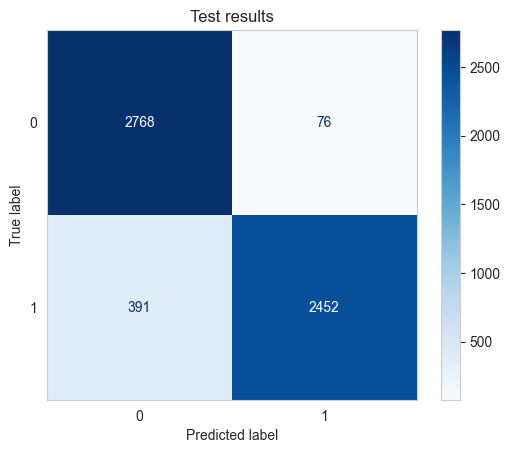

In [37]:
train(
    GaussianNB(),
    "recall",
    {"var_smoothing": [1e-9, 1e-8, 1e-5, 1e-3]},
)

DecisionTreeClassifier
Train score: 0.99
Test recall: 1.00
Best params: {'criterion': 'entropy', 'max_leaf_nodes': None, 'splitter': 'random'}


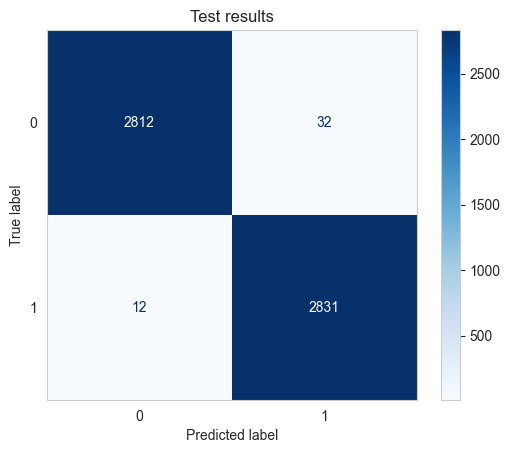

In [43]:
train(
    DecisionTreeClassifier(random_state=42),
    "recall",
    {
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "max_leaf_nodes": [None, 50, 100, 500],
    },
)

И вновь все модели показали себя хорошо.

- Хуже всех справился Naive Bayes (recall на тренировочной и тестовой выборках равен 0.86, при этом precision на тестовой выборке выше, хотя тренировка была нацелена именно на recall), однако, и отрабатывает он заметно быстрее остальных моделей
- Следующими стали обе модели с логистической регрессией (0.95 и 0.97 recall на обеих выборках у модели из scikit-learn и вручную реализованной модели соответственно), причем у реализованной вручную модели recall на тестовой выборке лучше, чем precision, а у модели из scikit-learn --- наоборот (опять же, обе модели тренировались с прицелом на recall)
- Ещё чуть лучше справился SVM-классификатор: recall 0.98--0.99, precision на тестовой выборке также 0.99
- Ещё лучше --- DecisionTreeClassifier: recall более 0.99, как и precision на тестовой выборке
- Лучше всех себя показали обе модели на основе KNN: у них на обеих выборках идеальный recall, да и precision на тестовой выборке около 0.99 --- однако, скорость работы данных моделей достаточно низка (особенно, у реализованной вручную)

Таким образом, для данного датасета лучше всего подходят KNN, но если требуется более высокая скорость работы, стоит также рассмотреть и остальные модели.